In [1]:
# Full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import os
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# 
from lib_modeling import *
from lib_feature_engineering import *

from sklearn import metrics
from sklearn.model_selection import train_test_split

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

# Load data

In [4]:
# load train/test data
data_path = "home-credit-default-risk/application_train.csv"
pdf_train = pd.read_csv(data_path)

data_path = "home-credit-default-risk/application_test.csv"
pdf_test = pd.read_csv(data_path)

# filter by tvt code
pdf_tvt_extend = pd.read_pickle("pdf_tvt_extend.pkl", compression="bz2")
pdf_train_filtered = (pdf_tvt_extend.query("tvt_code == 'train'")
                      .merge(pdf_train[["SK_ID_CURR"]], on="SK_ID_CURR")
                      .drop(columns=["tvt_code"]))
pdf_train_filtered.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [5]:
# load bureau + balance
data_path = "home-credit-default-risk/bureau.csv"
pdf_bureau = pd.read_csv(data_path)

data_path = "home-credit-default-risk/bureau_balance.csv"
pdf_bureau_balance = pd.read_csv(data_path)

# Calculate intermediate data (idata)

- status: binary, frequency
- count: number bureau, number bureau transaction

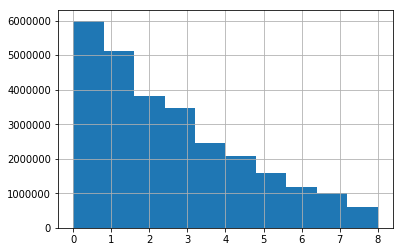

In [6]:
(pdf_bureau_balance["MONTHS_BALANCE"] / -12.0).hist()
plt.show()

In [7]:
# filter here for looking up balance within 1, 2, 3 years
pdf_bureau_balance["MONTHS_BALANCE"] = pdf_bureau_balance["MONTHS_BALANCE"] / -12
# pdf_bureau_balance = pdf_bureau_balance[(pdf_bureau_balance["MONTHS_BALANCE"] >= 1) & (pdf_bureau_balance["MONTHS_BALANCE"] < 1)]
# pdf_bureau_balance = pdf_bureau_balance[(pdf_bureau_balance["MONTHS_BALANCE"] >= 2) & (pdf_bureau_balance["MONTHS_BALANCE"] < 3)]
# pdf_bureau_balance = pdf_bureau_balance[pdf_bureau_balance["MONTHS_BALANCE"] >= 3]
# pdf_bureau_balance = pdf_bureau_balance[pdf_bureau_balance["MONTHS_BALANCE"] < 1]
pdf_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,-0.0000,C
1,5715448,0.0833,C
2,5715448,0.1667,C
3,5715448,0.2500,C
4,5715448,0.3333,C


In [8]:
pdf_bureau_balance["STATUS"].value_counts()

C    13646993
0    7499507 
X    5810482 
1    242347  
5    62406   
2    23419   
3    8924    
4    5847    
Name: STATUS, dtype: int64

In [9]:
# status in (1, 2, 3, 4) is DPD (date past due). 
# 5 is sold. C is closed. X is unknown. 0 is no DPD
pdf_bureau_balance.loc[pdf_bureau_balance["STATUS"].isin(['1', '2', '3', '4']), "STATUS"] = "DPD"
pdf_bureau_balance.loc[pdf_bureau_balance["STATUS"] == '5', "STATUS"] = "Sold"
pdf_bureau_balance["STATUS"].value_counts()

C       13646993
0       7499507 
X       5810482 
DPD     280537  
Sold    62406   
Name: STATUS, dtype: int64

In [10]:
%%time
dict_onehot = {
    "STATUS": ['C', '0', 'X', 'DPD', 'Sold'],
}
pdf_onehot = gen_one_hot_feat(pdf_bureau_balance, dict_onehot, main_key="SK_ID_BUREAU")
display(pdf_onehot.head())

,SK_ID_BUREAU,STATUS_C,STATUS_0,STATUS_X,STATUS_DPD,STATUS_Sold
0,5715448,1,0,0,0,0
1,5715448,1,0,0,0,0
2,5715448,1,0,0,0,0
3,5715448,1,0,0,0,0
4,5715448,1,0,0,0,0


CPU times: user 1min 1s, sys: 5.32 s, total: 1min 6s
Wall time: 51.5 s


In [11]:
%%time
pdf_idata01 = agg_common_data(pdf_onehot, ["max", "sum", "mean", "std"], main_key="SK_ID_BUREAU")
pdf_idata01.head()

{'STATUS_0': ['max', 'sum', 'mean', 'std'],
 'STATUS_C': ['max', 'sum', 'mean', 'std'],
 'STATUS_DPD': ['max', 'sum', 'mean', 'std'],
 'STATUS_Sold': ['max', 'sum', 'mean', 'std'],
 'STATUS_X': ['max', 'sum', 'mean', 'std']}

After agg: (817395, 20)
CPU times: user 14.3 s, sys: 1.81 s, total: 16.2 s
Wall time: 6.52 s


In [12]:
# 
pdf_idata02 = pdf_bureau_balance.groupby("SK_ID_BUREAU").size().to_frame("bureau_num_trans")
pdf_idata02.head()

,bureau_num_trans
SK_ID_BUREAU,
5001709,97
5001710,83
5001711,4
5001712,19
5001713,22


In [13]:
pdf_idata = pdf_idata01.join(pdf_idata02).reset_index()
pdf_idata.head()

,SK_ID_BUREAU,STATUS_Sold_max,STATUS_Sold_sum,STATUS_Sold_mean,STATUS_Sold_std,STATUS_X_max,STATUS_X_sum,STATUS_X_mean,STATUS_X_std,STATUS_C_max,STATUS_C_sum,STATUS_C_mean,STATUS_C_std,STATUS_DPD_max,STATUS_DPD_sum,STATUS_DPD_mean,STATUS_DPD_std,STATUS_0_max,STATUS_0_sum,STATUS_0_mean,STATUS_0_std,bureau_num_trans
0,5001709,0,0,0.0,0.0,1,11,0.1134,0.3187,1,86,0.8866,0.3187,0,0,0.0,0.0,0,0,0.0000,0.0000,97
1,5001710,0,0,0.0,0.0,1,30,0.3614,0.4833,1,48,0.5783,0.4968,0,0,0.0,0.0,1,5,0.0602,0.2394,83
2,5001711,0,0,0.0,0.0,1,1,0.2500,0.5000,0,0,0.0000,0.0000,0,0,0.0,0.0,1,3,0.7500,0.5000,4
3,5001712,0,0,0.0,0.0,0,0,0.0000,0.0000,1,9,0.4737,0.5130,0,0,0.0,0.0,1,10,0.5263,0.5130,19
4,5001713,0,0,0.0,0.0,1,22,1.0000,0.0000,0,0,0.0000,0.0000,0,0,0.0,0.0,0,0,0.0000,0.0000,22


# Feature engineering

In [14]:
# Join application to bureau balance
pdf_ids = pd.concat([pdf_train[["SK_ID_CURR"]], pdf_test[["SK_ID_CURR"]]])
pdf_data = (pdf_ids.merge(pdf_bureau[["SK_ID_CURR", "SK_ID_BUREAU"]], on="SK_ID_CURR")
            .merge(pdf_idata, on="SK_ID_BUREAU"))
print(pdf_data.shape)
pdf_data.head()

(774354, 23)


,SK_ID_CURR,SK_ID_BUREAU,STATUS_Sold_max,STATUS_Sold_sum,STATUS_Sold_mean,STATUS_Sold_std,STATUS_X_max,STATUS_X_sum,STATUS_X_mean,STATUS_X_std,STATUS_C_max,STATUS_C_sum,STATUS_C_mean,STATUS_C_std,STATUS_DPD_max,STATUS_DPD_sum,STATUS_DPD_mean,STATUS_DPD_std,STATUS_0_max,STATUS_0_sum,STATUS_0_mean,STATUS_0_std,bureau_num_trans
0,100002,6158904,0,0,0.0,0.0,1,1,0.0455,0.2132,1,2,0.0909,0.2942,1,1,0.0455,0.2132,1,18,0.8182,0.3948,22
1,100002,6158905,0,0,0.0,0.0,0,0,0.0000,0.0000,1,13,0.8125,0.4031,0,0,0.0000,0.0000,1,3,0.1875,0.4031,16
2,100002,6158906,0,0,0.0,0.0,1,3,0.1875,0.4031,1,2,0.1250,0.3416,1,6,0.3750,0.5000,1,5,0.3125,0.4787,16
3,100002,6158907,0,0,0.0,0.0,1,3,0.1875,0.4031,1,2,0.1250,0.3416,1,6,0.3750,0.5000,1,5,0.3125,0.4787,16
4,100002,6158908,0,0,0.0,0.0,0,0,0.0000,0.0000,0,0,0.0000,0.0000,1,2,0.5000,0.5774,1,2,0.5000,0.5774,4


In [15]:
# statistics on status_sum, bureau_num_trans
ls_cols = [cname for cname in pdf_data.columns if "_sum" in cname] + ["bureau_num_trans"]
pdf_stats = pdf_data[["SK_ID_CURR"] + ls_cols]
pdf_stats.head()

,SK_ID_CURR,STATUS_Sold_sum,STATUS_X_sum,STATUS_C_sum,STATUS_DPD_sum,STATUS_0_sum,bureau_num_trans
0,100002,0,1,2,1,18,22
1,100002,0,0,13,0,3,16
2,100002,0,3,2,6,5,16
3,100002,0,3,2,6,5,16
4,100002,0,0,0,2,2,4


In [16]:
pdf_agg01 = agg_common_data(pdf_stats, ["min", "max", "mean", "std", "median"])
pdf_agg01.head()

{'STATUS_0_sum': ['min', 'max', 'mean', 'std', 'median'],
 'STATUS_C_sum': ['min', 'max', 'mean', 'std', 'median'],
 'STATUS_DPD_sum': ['min', 'max', 'mean', 'std', 'median'],
 'STATUS_Sold_sum': ['min', 'max', 'mean', 'std', 'median'],
 'STATUS_X_sum': ['min', 'max', 'mean', 'std', 'median'],
 'bureau_num_trans': ['min', 'max', 'mean', 'std', 'median']}

After agg: (134542, 30)


,STATUS_C_sum_min,STATUS_C_sum_max,STATUS_C_sum_mean,STATUS_C_sum_std,STATUS_C_sum_median,bureau_num_trans_min,bureau_num_trans_max,bureau_num_trans_mean,bureau_num_trans_std,bureau_num_trans_median,STATUS_0_sum_min,STATUS_0_sum_max,STATUS_0_sum_mean,STATUS_0_sum_std,STATUS_0_sum_median,STATUS_DPD_sum_min,STATUS_DPD_sum_max,STATUS_DPD_sum_mean,STATUS_DPD_sum_std,STATUS_DPD_sum_median,STATUS_Sold_sum_min,STATUS_Sold_sum_max,STATUS_Sold_sum_mean,STATUS_Sold_sum_std,STATUS_Sold_sum_median,STATUS_X_sum_min,STATUS_X_sum_max,STATUS_X_sum_mean,STATUS_X_sum_std,STATUS_X_sum_median
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0,44,15.7143,16.9972,18.0,2,52,24.5714,16.0505,29.0,1,12,4.4286,4.8941,2.0,0,1,0.1429,0.3780,0.0,0,0,0.0,0.0,0.0,0,9,4.2857,3.8173,6.0
100002,0,13,2.8750,4.1897,2.0,4,22,13.7500,6.3640,16.0,2,18,5.6250,5.1807,5.0,0,6,3.3750,2.8754,4.0,0,0,0.0,0.0,0.0,0,3,1.8750,1.3562,2.5
100005,0,5,1.6667,2.8868,0.0,3,13,7.0000,5.2915,5.0,2,7,4.6667,2.5166,5.0,0,0,0.0000,0.0000,0.0,0,0,0.0,0.0,0.0,0,1,0.6667,0.5774,1.0
100010,26,26,26.0000,0.0000,26.0,36,36,36.0000,0.0000,36.0,10,10,10.0000,0.0000,10.0,0,0,0.0000,0.0000,0.0,0,0,0.0,0.0,0.0,0,0,0.0000,0.0000,0.0
100013,0,44,25.7500,20.7264,29.5,40,69,57.5000,13.1276,60.5,0,34,19.7500,14.5230,22.5,0,3,1.7500,1.2583,2.0,0,0,0.0,0.0,0.0,0,40,10.2500,19.8389,0.5


In [17]:
eval_agg01 = feature_evaluate(pdf_train_filtered, pdf_agg01.reset_index())
display(eval_agg01)

,name,auc,corr,coverage
7,bureau_num_trans_mean,0.5928,-0.0785,1.0000
9,bureau_num_trans_median,0.5899,-0.0744,1.0000
6,bureau_num_trans_max,0.5728,-0.0668,1.0000
2,STATUS_C_sum_mean,0.5717,-0.0618,1.0000
5,bureau_num_trans_min,0.5708,-0.0459,1.0000
4,STATUS_C_sum_median,0.5632,-0.0559,1.0000
1,STATUS_C_sum_max,0.5625,-0.0591,1.0000
3,STATUS_C_sum_std,0.5596,-0.0542,0.8679
8,bureau_num_trans_std,0.5523,-0.0458,0.8679
12,STATUS_0_sum_mean,0.5426,-0.0387,1.0000


In [18]:
# keep binary values
ls_cols = [cname for cname in pdf_data.columns if "_max" in cname]
pdf_binary = pdf_data[["SK_ID_CURR"] + ls_cols]
pdf_binary.head()

,SK_ID_CURR,STATUS_Sold_max,STATUS_X_max,STATUS_C_max,STATUS_DPD_max,STATUS_0_max
0,100002,0,1,1,1,1
1,100002,0,0,1,0,1
2,100002,0,1,1,1,1
3,100002,0,1,1,1,1
4,100002,0,0,0,1,1


In [19]:
pdf_agg02 = agg_common_data(pdf_binary, ["max"])
pdf_agg02.head()

{'STATUS_0_max': ['max'],
 'STATUS_C_max': ['max'],
 'STATUS_DPD_max': ['max'],
 'STATUS_Sold_max': ['max'],
 'STATUS_X_max': ['max']}

After agg: (134542, 5)


,STATUS_0_max_max,STATUS_Sold_max_max,STATUS_X_max_max,STATUS_DPD_max_max,STATUS_C_max_max
SK_ID_CURR,,,,,
100001,1,0,1,1,1
100002,1,0,1,1,1
100005,1,0,1,0,1
100010,1,0,0,0,1
100013,1,0,1,1,1


In [20]:
eval_agg02 = feature_evaluate(pdf_train_filtered, pdf_agg02.reset_index())
display(eval_agg02)

,name,auc,corr,coverage
3,STATUS_DPD_max_max,0.5378,0.0440,1.0
4,STATUS_C_max_max,0.5246,-0.0335,1.0
1,STATUS_Sold_max_max,0.5045,0.0161,1.0
2,STATUS_X_max_max,0.5020,0.0027,1.0
0,STATUS_0_max_max,0.5001,0.0003,1.0


# save features

In [21]:
pdf_feat = pdf_agg01.join(pdf_agg02)
print(pdf_feat.shape)
pdf_feat.head()

(134542, 35)


,STATUS_C_sum_min,STATUS_C_sum_max,STATUS_C_sum_mean,STATUS_C_sum_std,STATUS_C_sum_median,bureau_num_trans_min,bureau_num_trans_max,bureau_num_trans_mean,bureau_num_trans_std,bureau_num_trans_median,STATUS_0_sum_min,STATUS_0_sum_max,STATUS_0_sum_mean,STATUS_0_sum_std,STATUS_0_sum_median,STATUS_DPD_sum_min,STATUS_DPD_sum_max,STATUS_DPD_sum_mean,STATUS_DPD_sum_std,STATUS_DPD_sum_median,STATUS_Sold_sum_min,STATUS_Sold_sum_max,STATUS_Sold_sum_mean,STATUS_Sold_sum_std,STATUS_Sold_sum_median,STATUS_X_sum_min,STATUS_X_sum_max,STATUS_X_sum_mean,STATUS_X_sum_std,STATUS_X_sum_median,STATUS_0_max_max,STATUS_Sold_max_max,STATUS_X_max_max,STATUS_DPD_max_max,STATUS_C_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0,44,15.7143,16.9972,18.0,2,52,24.5714,16.0505,29.0,1,12,4.4286,4.8941,2.0,0,1,0.1429,0.3780,0.0,0,0,0.0,0.0,0.0,0,9,4.2857,3.8173,6.0,1,0,1,1,1
100002,0,13,2.8750,4.1897,2.0,4,22,13.7500,6.3640,16.0,2,18,5.6250,5.1807,5.0,0,6,3.3750,2.8754,4.0,0,0,0.0,0.0,0.0,0,3,1.8750,1.3562,2.5,1,0,1,1,1
100005,0,5,1.6667,2.8868,0.0,3,13,7.0000,5.2915,5.0,2,7,4.6667,2.5166,5.0,0,0,0.0000,0.0000,0.0,0,0,0.0,0.0,0.0,0,1,0.6667,0.5774,1.0,1,0,1,0,1
100010,26,26,26.0000,0.0000,26.0,36,36,36.0000,0.0000,36.0,10,10,10.0000,0.0000,10.0,0,0,0.0000,0.0000,0.0,0,0,0.0,0.0,0.0,0,0,0.0000,0.0000,0.0,1,0,0,0,1
100013,0,44,25.7500,20.7264,29.5,40,69,57.5000,13.1276,60.5,0,34,19.7500,14.5230,22.5,0,3,1.7500,1.2583,2.0,0,0,0.0,0.0,0.0,0,40,10.2500,19.8389,0.5,1,0,1,1,1


In [22]:
%%time
fname = "bureau_balance"
# fname = "bureau_balance_1year"
# fname = "bureau_balance_2year"
# fname = "bureau_balance_gt3year"
# fname = "bureau_balance_lt1year"

fname = os.path.join("features", "{}.pkl.bz2".format(fname))
pdf_feat.to_pickle(fname, compression="bz2")
print("Store features completed!")


Store features completed!
CPU times: user 3.03 s, sys: 40.9 ms, total: 3.07 s
Wall time: 1.7 s
